# Bias Correct GFS Precipitation Forecast

In this exercise, we will bias correct a previously-obtained GFS forecast

### Import modules and set configurations

In [16]:
# Find the directory of the current project and add to PATH
import sys, os, arcpy
home_folder = arcpy.mp.ArcGISProject("current").homeFolder
sys.path.insert(0, home_folder)
os.chdir(home_folder)

# The 00_environment_setup notebook contains libraries and other things common to all the notebooks (e.g. file paths)
%run "00_environment_setup.ipynb"

Active Portal in ArcGIS Pro
Logged in as ksampson
Current conda environment:
	arcgispro-py3-clone C:\Users\ksampson\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone
Found input data directory: C:\Users\ksampson\Desktop\GloFAS_Q2Q_Bias_Correction_and_Verification\data\input
Completed importing and/or installing libraries in 4.51 seconds.


We can add the scripts directory to our PATH environment and import the python scripts as if they were modules.

In [17]:
# To import scripts from the \scripts directory, we need to add a relative path that will be 2 directories above this Notebook
sys.path.insert(0, os.path.abspath('..\..\scripts'))

# Import local scripts from the \scripts directory
use_cartopy=False
import forecast_preprocess
import definitions
import read_input_file_xarray
if use_cartopy:
    import plotting_utils

## Set configuration parameters

In [18]:
regridding=False

#If true, then diagnostic plots will be created
diagnostic_plots=True

Other configuration details for the datasets and grids used are in definitions.py

In [19]:
#Date to run (sample data, for now.  Will be realtime)
date=datetime(2023,10,25,0,0)

#Observations to use as reference
obs='IMDobs'

#Realtime input forecast model, details about the input files from this model are given in the definitions.py file
model='gfs' 
realtime_acc=3
archive_acc=24
acc_str='hr'

#Common grid to be used in analysis (defined in definitions.py file)
grid = 'india_0p25deg'

# Forecast start and end times
fcst_archive_start=datetime(2016,1,1)
fcst_archive_end=datetime(2020,12,31)

# Observation start and end times
obs_archive_start=datetime(2016,1,1)
obs_archive_end=datetime(2019,12,31)

### Construct the expected archive filenames

In [20]:
# Observation Archive
obs_filename = '{0}_{1}_{2}{3}_{4}_to_{5}.nc'.format(obs, 
                                                     grid, 
                                                     archive_acc, 
                                                     acc_str, 
                                                     obs_archive_start.strftime('%Y%m%d'), 
                                                     obs_archive_end.strftime('%Y%m%d'))
obs_archive_file = os.path.join(input_data_dir, 'archives', obs_filename)

# Forecast Archive
forecast_filename = '{0}_{1}_{2}{3}_{4}_to_{5}.nc'.format(model, 
                                                     grid, 
                                                     archive_acc, 
                                                     acc_str, 
                                                     fcst_archive_start.strftime('%Y%m%d'), 
                                                     fcst_archive_end.strftime('%Y%m%d'))
forecast_archive_file = os.path.join(input_data_dir, 'archives', forecast_filename)

# Forecast Realtime File
if regridding==False:
    #If we already have a realtime forecast on the correct grid, then we don't need regridding
    # and we will specify this realtime forecast file name.      
    forecast_rt_filename = '{0}_0p25_1hr_{1}z_{2}{3}_daily.nc'.format(model,
                                                                            date.strftime('%H'),
                                                                            model,
                                                                            date.strftime('%Y%m%d'))
    forecast_realtime_file = os.path.join(output_data_dir, forecast_rt_filename)
                                          
elif regridding==True:
    #Otherwise, we will be using raw forecasts downloaded from the web and these will processed to netcdf on an appropriate grid.
    #In this case, reading the forecasts will be done using the the sub-routines in read_input_files_xarray.py, using the key below
    realtime_modelkey=model+'_'+str(realtime_acc)+acc_str 

diag_plot_dir = os.path.join(output_data_dir, 'diagnostic_plots', model)
if diagnostic_plots:
    if not os.path.exists(diag_plot_dir):
        os.makedirs(diag_plot_dir)

### Open the archived observation dataset as a `xarray` DataSet object

In [21]:
print(obs_archive_file)
ds_obs = xr.open_dataset(obs_archive_file)
ds_obs

C:\Users\ksampson\Desktop\GloFAS_Q2Q_Bias_Correction_and_Verification\data\input\archives\IMDobs_india_0p25deg_24hr_20160101_to_20191231.nc


<xarray.Dataset>
Dimensions:        (start_date: 1461, lat: 129, lon: 135)
Coordinates:
  * start_date     (start_date) datetime64[ns] 2016-01-01 ... 2019-12-31
  * lat            (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.75 38.0 38.25 38.5
  * lon            (lon) float64 66.5 66.75 67.0 67.25 ... 99.5 99.75 100.0
Data variables:
    Precipitation  (start_date, lat, lon) float32 ...

### Manipulate the archived observation dataset and plot over time

Wall time: 120 ms


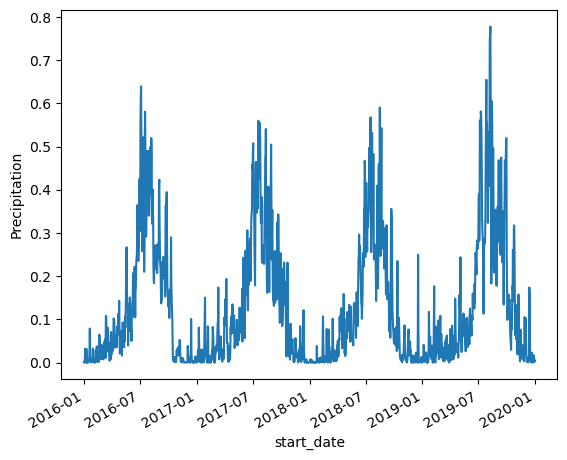

In [22]:
%%time
%matplotlib inline

# Compute the mean over latitude and longitude dimensions, then plot
ds_obs['Precipitation'].mean(('lat','lon')).plot()

Wall time: 88.8 ms


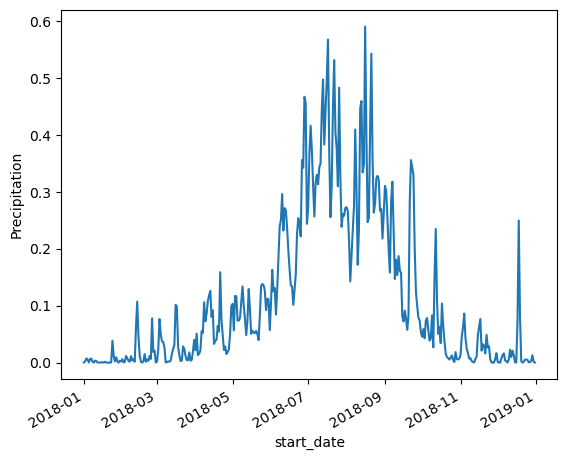

In [23]:
%%time
%matplotlib inline

# Compute mean over latitude and longitude dimensions and select dates in year 2018, then plot
ds_obs['Precipitation'].mean(('lat','lon')).sel(start_date=ds_obs.start_date.dt.year.isin([2018])).plot()

### Open the archived forecast dataset as a `xarray` DataSet object

In [24]:
print(forecast_archive_file)
ds_fcst = xr.open_dataset(forecast_archive_file)
ds_fcst

C:\Users\ksampson\Desktop\GloFAS_Q2Q_Bias_Correction_and_Verification\data\input\archives\gfs_india_0p25deg_24hr_20160101_to_20201231.nc


<xarray.Dataset>
Dimensions:              (initialization_date: 1827, ensemble: 1, lead: 10, lat: 129, lon: 135)
Coordinates:
  * initialization_date  (initialization_date) datetime64[ns] 2016-01-01 ... ...
  * ensemble             (ensemble) int64 1
  * lead                 (lead) int64 0 24 48 72 96 120 144 168 192 216
  * lat                  (lat) float64 6.5 6.75 7.0 7.25 ... 38.0 38.25 38.5
  * lon                  (lon) float64 66.5 66.75 67.0 ... 99.5 99.75 100.0
Data variables:
    Precipitation        (initialization_date, ensemble, lead, lat, lon) float64 ...
    start_date           (initialization_date, lead) datetime64[ns] 2016-01-0...
    end_date             (initialization_date, lead) datetime64[ns] 2016-01-0...

### Manipulate the archived forecast dataset and plot over time

Wall time: 2.77 s


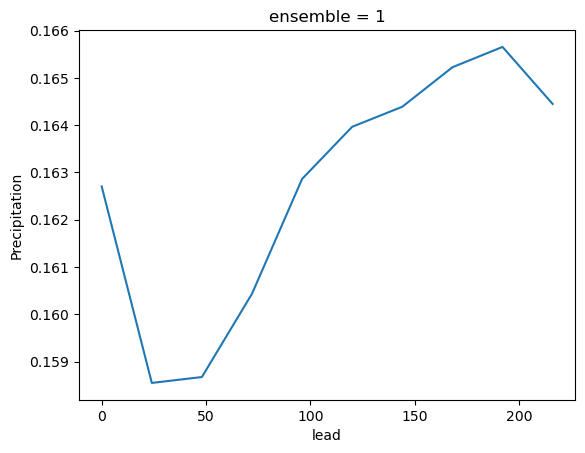

In [25]:
%%time
%matplotlib inline

# Compute the mean over latitude and longitude dimensions, then plot
ds_fcst['Precipitation'].mean(('lat', 'lon')).mean('initialization_date').plot()

### Plot a sample location

Text(0.5, 1.0, 'Sorted Archived Rainfall values for (17.75 ,78.25)')

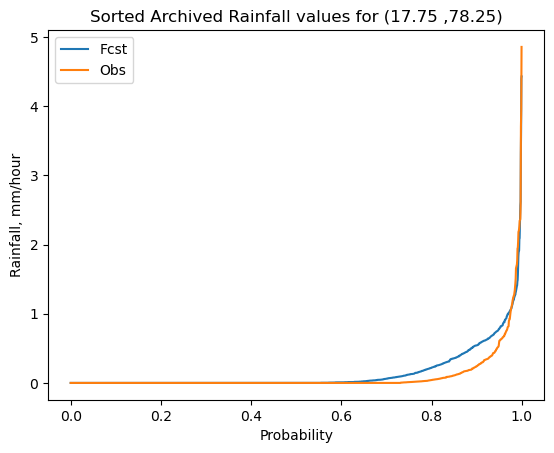

In [26]:
test_lat=17.75
test_lon=78.25
obs_sorted=np.sort(ds_obs.Precipitation.sel(lat=test_lat).sel(lon=test_lon).dropna(dim='start_date').values)
fcst_sorted=np.sort(ds_fcst.Precipitation.sel(lat=17.75).sel(lon=78.25)[:,0,5].dropna(dim='initialization_date').values)
x_fcst_sorted=np.arange(0,1,1/len(fcst_sorted))
x_obs_sorted=np.arange(0,1,1/len(obs_sorted))
fcst_line=plt.plot(x_fcst_sorted,fcst_sorted)

#Restrict range of y axis to explore behavior at lower rainfall amounts, if desired
#plt.ylim((0,2))
#plt.ylim((0,2))
obs_line=plt.plot(x_obs_sorted,obs_sorted)
plt.legend(['Fcst','Obs'])
plt.ylabel("Rainfall, mm/hour")
plt.xlabel("Probability")
plt.title("Sorted Archived Rainfall values for ("+str(test_lat)+" ,"+str(test_lon)+")")

## Create input for regridding if needed

Setup regridding dictionary

In [27]:
if regridding==True:
    regrid_in={}

    #Use conservative for going from a fine to course grid #Use biliear for going from a course to fine grid
    regrid_in['regrid_type'] = 'conservative'
    regrid_in['forecast_key'] = realtime_modelkey

    #input from Kevin's NOMADS GFS code
    regrid_in['input_filetype']='daily_netcdf'

    regrid_in['model'] = model
    regrid_in['output_grid'] = grid

    #Input data is 3 hour averages
    regrid_in['input_acc'] = realtime_acc

    #Output data is 24 hour averages
    regrid_in['output_acc'] = archive_acc

    # Outputs
    regrid_in['out_data_dir'] = os.path.join(output_data_dir, 'realtime_sample_data', model, 'regridded', date.strftime('%Y'))
    regrid_in['out_data_fn'] = os.path.join(regrid_in['out_data_dir'], '{0}_{1}_{2}{3}_{4}.nc'.format(model, grid, archive_acc, acc_str, date.strftime('%Y%m%d%H')))
    regrid_in['diagnostics'] = diagnostic_plots
    regrid_in['diag_plots_dir'] = diag_plot_dir
    regrid_in['use_cartopy'] = use_cartopy

## Run regridding if needed, otherwise read forecast file

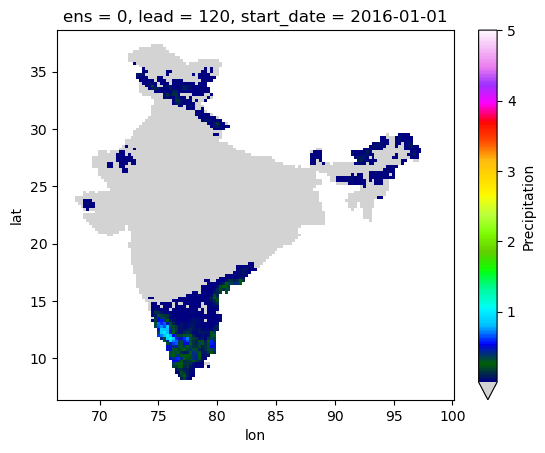

In [28]:
if regridding==True:
    #Read in raw downloaded NOMADS data and put them in a netcdf file in the format needed for multi-dimensional bias-corretion
    ds_out = forecast_preprocess.regrid_forecast(date,regrid_in)
    
elif regridding==False:
    #Read in netcdf file, and put in format needed for multi-dimensional bias-correction
    ds=xr.open_dataset(forecast_realtime_file)
    ds_out=xr.Dataset(data_vars=dict(Precipitation=(["ens","lead","lat","lon"],ds.pr.transpose("time","lat","lon").expand_dims(dim={"ens":1}).values),\
                        start_date=(["lead"],ds.time.values)),\
                        coords=dict(ens=("ens",[0]),lead=("lead",np.arange(0,240,24)),lat=("lat",ds.lat.values),\
                        lon=("lon",ds.lon.values)))
    if diagnostic_plots:
        if use_cartopy:
            plotting_utils.basic_map_gridplot(ds_out.Precipitation[0,5,:,:],diag_plots_dir+'regridded_'+model+'_'+date.strftime('%Y%m%d%H')+'_lead5.png',10)
        else: 
            #CHANGED SEGMENT BELOW to add new color bar and scaling, as well as mask out non-india points to match other plot
            india_mask=(ds_obs.Precipitation[0,:,:]+1)/(ds_obs.Precipitation[0,:,:]+1)
            values_to_plot=ds_out.Precipitation[0,5,:,:]*india_mask
            cmap = matplotlib.colormaps['gist_ncar']  # Color ramp suitable for precipiation
            cmap.set_under('lightgrey')               # Set values of zero precipitation to grey
            values_to_plot.plot(cmap=cmap,vmin=0.001,vmax=5)

In [29]:
ds_out

<xarray.Dataset>
Dimensions:        (ens: 1, lead: 10, lat: 129, lon: 135)
Coordinates:
  * ens            (ens) int32 0
  * lead           (lead) int32 0 24 48 72 96 120 144 168 192 216
  * lat            (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.75 38.0 38.25 38.5
  * lon            (lon) float64 66.5 66.75 67.0 67.25 ... 99.5 99.75 100.0
Data variables:
    Precipitation  (ens, lead, lat, lon) float32 0.3125 0.3125 ... 0.07552
    start_date     (lead) datetime64[ns] 2023-10-25 2023-10-26 ... 2023-11-03

## Create input for quantile mapping

Setup Q2Q dictionary

In [30]:
q2q_in={}
q2q_in['obs_archive_file']=obs_archive_file
q2q_in['forecast_archive_file']=forecast_archive_file

#Perform bias correction only on same hour of day
q2q_in['diurnal_cycle_filter']=False 

#Perform bias correction only on same month of the year
q2q_in['seasonal_cycle_filter']=False

# Outputs
q2q_in['out_data_dir']=os.path.join(output_data_dir, 
                                    'realtime_sample_data', 
                                    model, 
                                    'q2q_corrected')
q2q_in['out_data_fn']=os.path.join(q2q_in['out_data_dir'], 
                                   '{0}_{1}_{2}{3}_{4}.nc'.format(model, 
                                                                  grid, 
                                                                  archive_acc, 
                                                                  acc_str, 
                                                                  date.strftime('%Y%m%d%H')))    
    
# Other options
q2q_in['diagnostics']=diagnostic_plots
q2q_in['diag_plots_dir']=diag_plot_dir
q2q_in['date']=date
q2q_in['acc_period_str']=str(archive_acc)+acc_str
q2q_in['forecast_model']=model #'wrf_belize','gfs_ncar_ds85p1','gfs_hires_3hrly','cmc'
q2q_in['use_cartopy']=use_cartopy

## Run quantile mapping

Wall time: 15.7 s


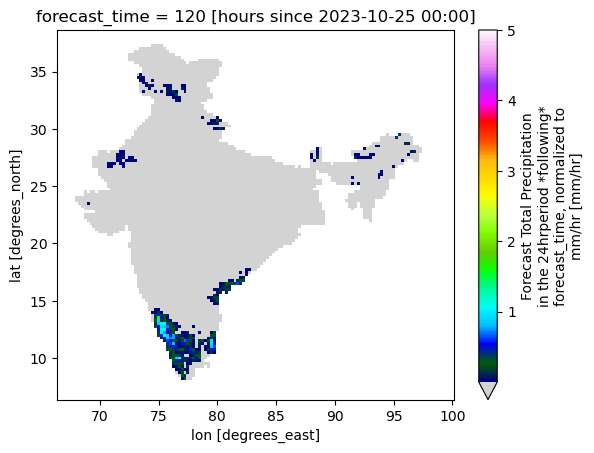

In [31]:
%%time

pcp_adjusted=forecast_preprocess.bias_correct_forecast(q2q_in,ds_out)

In [32]:
pcp_adjusted

<xarray.Dataset>
Dimensions:        (time: 10, lat: 129, lon: 135)
Coordinates:
  * lat            (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.75 38.0 38.25 38.5
  * lon            (lon) float64 66.5 66.75 67.0 67.25 ... 99.5 99.75 100.0
    forecast_time  (time) int64 0 24 48 72 96 120 144 168 192 216
Dimensions without coordinates: time
Data variables:
    Precipitation  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:  CF-1.7
    title:        Forecast model run with bias correction
    source:       gfs
    history:      2023-10-27 05:23:13.596384 Python
    comment:      This file has been bias corrected using C:\Users\ksampson\D...

### Reset the namespace

The following `%reset -f` command is a built-in command in Jupyter Notebook that will reset the namespace. This is good practice to run when you are finished with the notebook.

In [ ]:
%reset -f